### Nava Roohi 
### ADS 509 Assignment 5.1: Topic Modeling
### 06/13/2022

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [58]:
# These libraries may be useful to you

from nltk.corpus import brown
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import regex as re

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import nltk
import random
import collections

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')
from nltk.probability import FreqDist


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
from nltk.corpus import brown
brown.words()

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


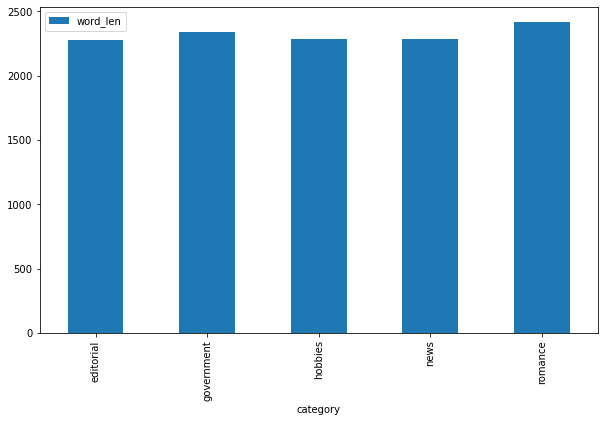

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Count text vectors hold document term matrices which have been basically transfered from texts to vectors on the basis of frequency of each word that has occured in the entire texy. TFIDF is also term frquency-Inverse document frequency which contains information about less relevant and more relevant words in a document.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

In [16]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def remove_stop(tokens):
   return [t for t in tokens if t.lower() not in stopwords]

def tokenize(text):
   return re.findall(r'[\w-]*\p{L}[\w-]*', text)


pipeline = [str.lower, tokenize, remove_stop]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline: 
       tokens = transform(tokens)
    return tokens


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
news_df=df[df['category']=='news']
news_list2 =news_df ['tokens'].apply(pd.Series).stack() 
fdist = FreqDist(news_list2)
common_words_news = fdist.most_common(5)
print("For the category of news,the top five words are :"+ str(common_words_news))
print("-----------------------------------------------------------------------")


hobbies_df=df[df['category']=='hobbies']
hobbies_list =hobbies_df['tokens'].apply(pd.Series).stack() 
fdist_hobbies = FreqDist(hobbies_list)
common_words_hobbies = fdist_hobbies.most_common(5)
print("For the category of Hobbies,the top five words are :"+ str(common_words_hobbies))
print("-----------------------------------------------------------------------")

gov_df=df[df['category']=='government']
gov_list=gov_df['tokens'].apply(pd.Series).stack() 
fdist_gov=FreqDist(gov_list)
common_words_gov = fdist_gov.most_common(5)
print("For the category of government,the top five words are :"+ str(common_words_gov))
print("-----------------------------------------------------------------------")


romance_df=df[df['category']=='romance']
romance_list=romance_df['tokens'].apply(pd.Series).stack() 
fdist_romance=FreqDist(romance_list)
common_words_romance = fdist_romance.most_common(5)
print("For the category of romance,the top five words are :"+ str(common_words_romance))
print("-----------------------------------------------------------------------")

edit_df=df[df['category']=='editorial']
edit_list=edit_df['tokens'].apply(pd.Series).stack() 
fdist_edit=FreqDist(edit_list)
common_words_editoial= fdist_edit.most_common(5)
print("For the category of editorial,the top five words are :"+ str(common_words_editoial))
print("----------------------------------------------")

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For the category of news,the top five words are :[('said', 406), ('mrs', 254), ('would', 246), ('new', 241), ('one', 214)]
-----------------------------------------------------------------------
For the category of Hobbies,the top five words are :[('one', 286), ('new', 149), ('may', 143), ('time', 133), ('first', 126)]
-----------------------------------------------------------------------
For the category of government,the top five words are :[('state', 217), ('year', 187), ('states', 184), ('may', 179), ('united', 155)]
-----------------------------------------------------------------------
For the category of romance,the top five words are :[('said', 331), ('would', 247), ('could', 196), ('like', 189), ('one', 186)]
-----------------------------------------------------------------------
For the category of editorial,the top five words are :[('would', 185), ('one', 174), ('new', 134), ('mr', 110), ('people', 83)]
----------------------------------------------


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: <!-- Your answer here --> There seems to be not so much overlap and similarities among the top 5 words in the original Brown categories and five topic NMF model.However,There were some words such as "one","said","mrs","mr" which were overlaping.overal, original brown categories didnt show so much consistency in it's topics. While NMF, we could see quite consistency.for instance, Topic 00 could be politic related( Kennedy and Khrunchev).or topic 04 could be related to sport, baseball.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [84]:
from sklearn.decomposition import TruncatedSVD
svd_text_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_text_model.components_

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> There doesn't seem to be so much overlap here again between the LSA model and original Brown categories. LSA model turned out to be more consistent among it's topics compared to original brown categories and less consistent compared to NMF. 

In [85]:

display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.06)
  kennedy (0.82)
  laos (0.78)

Topic 03
  mrs (29.99)
  club (6.67)
  game (6.21)
  jr (5.71)
  dallas (5.47)

Topic 04
  game (4.46)
  league (3.20)
  baseball (3.18)
  ball (3.02)
  team (2.91)

Topic 05
  mrs (4.51)
  music (1.15)
  af (1.09)
  khrushchev (1.04)
  miss (0.98)

Topic 06
  faculty (184.24)
  college (178.80)
  student (139.55)
  shall (123.17)
  university (114.98)

Topic 07
  mrs (10.11)
  sales (5.92)
  marketing (4.33)
  billion (4.33)
  business (4.01)

Topic 08
  state (26.37)
  states (18.26)
  united (16.73)
  shall (15.81)
  mrs (15.67)

Topic 09
  shall (19.61)
  united (17.02)
  board (14.47)
  states (11.02)
  court (10.58)


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output? 

A: overal, display topics demonstrated more consistency compared to the original brown categories. display topic shows topic which are created by the model and the words relevant to it. This is why we see more consistency among display topic outputs. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [27]:
lda_text_model= LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())
lda_text_model



Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=5, random_state=314)

Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here --> the words we get from displayed topis from LDA model had much more overlap with original brown categories compared to NMF and LSA model. LDA works by  attaching topical content to the text document. when we look at the result of running LDA compared to NMF, we can say NMF provided better undesrtanding than the topics generated by LDA. 


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> Overall, there seems to be  more similarity between LDA topics and the Brown categories compared to other models. However, this similiarity is mostly limmited to politic and givernment section and not in romance and hobby categories.

In [31]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [37]:
pyLDAvis.display(lda_display)

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> In general LDA operates in the same way as PCA does. when LDA applies to the text data, it works by decomposing the corpus document word matrix(larger matrix) in to smaller matrices.Therefore,  from the principal component scatter plot, we can see that each topic is clearly seprated from  each other and they are each unique and overal there  doesn't seem to be any overlap between the topics. We can see that topic 4 and 5 have the smallerst relative terms and topic 3 has the largest topic in relative terms. 



In [43]:
import IPython
IPython.__version__

/Users/navaroohi/opt/anaconda3/envs/Desktop/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'7.21.0'